# HMM inference and MAP estimation in Gilbert-Elliot channel model 
## TensorFlow implementation of potential based HMM and the parallel version of it.

This notebook implements the algorithms from Ref.[2]

[2] S. S. Hassan, S. Särkkä and Á. F. García-Fernández (2021). __Temporal Parallelization of Inference in Hidden Markov Models__. *__IEEE Transactions on Signal Processing__*, Volume: 69, Pages 4875-4887. DOI: [10.1109/TSP.2021.3103338](https://doi.org/10.1109/TSP.2021.3103338)



### Imports and utilities

In [1]:
# Python specific imports that will make our job easier and our code prettier
from collections import namedtuple
from functools import partial
import math
import time
from tqdm.auto import trange, tqdm


# TF specific imports that we will use to code the logic
from tensorflow import function
import tensorflow as tf
import tensorflow_probability as tfp

# Auxiliary libraries that we will use to report results and create the data
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

# Utilities
mm = tf.linalg.matmul
mv = tf.linalg.matvec

# device = '/TPU:0'
device = '/GPU:0'

# check if device is available
# tf.test.is_gpu_available()

### Model

We consider the Gilbert-Elliot channel model. This is  a classical model used in the transmission of signals in digital communication channels. We consider two inputs: one for input signal and another for channel regime signal. They are binary signals and represented by $b_k$ and $s_k$, respectively. 

The input signal $b_k$ is flipped by an idependendent error. We can model this as 
$$
y_k = b_k \oplus v_k
$$

The regime channel signal $s_k$ is represented as two states hidden Markov model, which can have either a good or a bad channel condition. The good state has a low probability error, while the bad state can have a high probability error. If $v_k = 1$ i.e. an error occurs, where $y_k \neq b_k$, then

- $q_0$ represents the probability of the error in the good state.
- $q_1$ represents the probability of the error in the bad state.

The transition probability can be represented as

- $p_0$: transition from high error state (bad state) to low error state (good state).
- $p_1$: transition from low error state (good state) to high error state (bad state).
- $p_2$: switching probability of $b_k$.

The joint model $x_k = (s_k, b_k)$ is a four-state Markov chain. That is,
$$
x_k = \{(0, 0), (0, 1), (1, 0), (1, 1)\}
$$ 
and encoded as $\{0, 1, 2, 3\}$. Our transition and observation matrices are as follows:


$$
\Pi = p(x_k \mid x_{k-1}) = \begin{pmatrix}
(1 - p_0)(1 - p_2) & p_0 (1 - p_2)   & (1 - p_0)p_2        & p_0 p_2 \\  
p_1 (1 - p_2)      & (1-p_1) (1-p_2) & p_1 p_2             & (1- p_1) p_2 \\
(1 - p_0)          & p_0 p_2         & (1 - p_0) (1 - p_2) & p_0  (1 - p_2) \\
p_1 p_2            & (1 - p_1)p_2    & p_1 (1 - p_2)       & (1 - p_1) (1 - p_2)
\end{pmatrix}
$$

and

$$
O = p(y_k\mid x_k) = \begin{pmatrix}
(1 - q_0) & q_0 \\
(1 - q_1) & q_1 \\
q_0 & (1 - q_0) \\
q_1 & (1 - q_1)
\end{pmatrix}
$$





In [2]:
class HMMModel:
    def __init__(self, p0=0.03,  p1=0.1, p2=0.05, q0=0.01, q1=0.1):
        """Gilbert-Elliot channel model.
        
        :math:``
            p0: `P(S_{k+1} = 1 | S_{k} = 0)`
            p1: `P(S_{k+1} = 0 | S_{k} = 1)`
            p2: `P(B_{k+1} = 1 | B_{k} = 0) = P(B_{k+1} = 0 | B_{k} = 1)`
            q0: `P(Y_k != b | B_k = b, S_k = 0)`
            q1: `P(Y_k != b | B_k = b, S_k = 1)`
        
        """
        # transition matrix
        self.np_Pi = np.array([
                               [(1-p0)*(1-p2), p0*(1-p2),     (1-p0)*p2,     p0*p2],
                               [p1*(1-p2),     (1-p1)*(1-p2), p1*p2,         (1-p1)*p2],
                               [(1-p0)*p2,     p0*p2,         (1-p0)*(1-p2), p0*(1-p2)],
                               [p1*p2,         (1-p1)*p2,     p1*(1-p2),     (1-p1)*(1-p2)]
                               ])
        
        # observation matrix
        self.np_Po = np.array([ 
                               [(1-q0), q0],
                               [(1-q1), q1],
                               [q0, (1-q0)],
                               [q1, (1-q1)]
                            ])

        # prior
        self.np_prior = np.array([0.25, 0.25, 0.25, 0.25])

        # convert to tensor
        self.Pi    = tf.convert_to_tensor(self.np_Pi)
        self.Po    = tf.convert_to_tensor(self.np_Po)
        self.prior = tf.convert_to_tensor(self.np_prior)
        
        # dimensions
        self.Pi_dim = self.Pi.shape[-1]
        self.Po_dim = self.Po.shape[-1]
        self.prior_dim = self.prior.shape[-1]

        # transition, observation, and prior in log-space
        self.log_Pi    = tf.math.log(self.Pi)
        self.log_Po    = tf.math.log(self.Po)
        self.log_prior = tf.math.log(self.prior)


In [3]:
def catrnd(rng, p):
    if p.ndim > 1:
        p = p.squeeze()
    
    return rng.choice(p.shape[0], size=1,  p=p)
    

def simulate_data(model: HMMModel, steps:int, seed:int=1):
    rng = np.random.default_rng(seed)
    
    X = np.zeros((steps, 1))
    Y = np.zeros(steps, dtype=np.int32)
    x = catrnd(rng, model.np_prior)
    
    for k in range(steps):
        if k > 0:
            x = catrnd(rng, model.np_Pi[x])
        y = catrnd(rng, model.np_Po[x])
        X[k] = x
        Y[k] = y
    
    return X, Y


#### Initialize the parameters

In [4]:
log10T = 5
nsteps = 100
T = np.arange(10 ** log10T)+1

#### Initialize the model

In [5]:
model = HMMModel()

#### Simulate the data

In [6]:
X,Y = simulate_data(model,10 ** log10T)

#### Plot the simulated data

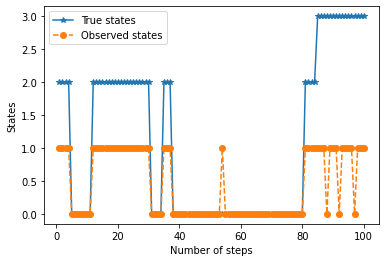

In [7]:
plt.plot(T[:nsteps], X[:nsteps], '*-', T[:nsteps], Y[:nsteps], 'o--')
plt.xlabel('Number of steps')
plt.ylabel('States')
plt.legend(['True states', 'Observed states'])

### Reference implementations for comparison and debugging
Here, we have implemented forward-backward potential based filter-smoother summarized in Algorithm 1 of the article. 

In [8]:
def ref_fwdbwd_filter_smoother(model, Y):
    """Reference Forward-Backward Filter and smoother
    
    Parameters
    ----------
    model: 
        HMM model
    Y: array_like
        Observations
    Returns
    -------
    fest: 
        filtering estimates
    sest: 
        smoother estimates
    all_psi_f: 
        all forward potentials
    all_psi_b: 
        all backward potentials
    """
    
    all_psi_f = np.zeros((Y.shape[0], model.Pi_dim))
    fest = np.zeros((Y.shape[0], model.Pi_dim))
    for k in range(len(Y)):
        if k > 0:
            psi   = model.np_Po[:, Y[k]] * model.np_Pi
            psi_f = psi_f @ psi
        else:
            psi_f = model.np_Po[:, Y[k]] * model.np_prior
        all_psi_f[k] = psi_f
        fest[k] = psi_f / np.sum(psi_f)
    
    psi_b = np.ones(psi_f.shape)
    
    all_psi_b = all_psi_f.copy()
    all_psi_b[-1] = psi_b
    
    for k in reversed(range(len(Y)-1)):
        psi   = model.np_Po[:,Y[k+1]] * model.np_Pi
        psi_b = psi @ psi_b
        all_psi_b[k] = psi_b
    
    sest = []
    for f,b in zip(all_psi_f, all_psi_b):
        p = f * b
        p = p / np.sum(p)
        sest.append(p)
        
    return fest, sest, all_psi_f, all_psi_b

### Plots for reference Bayesian and  forward-backward filters and smoothers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


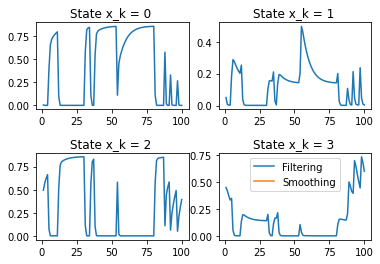

In [10]:
ref_fwdbwd_fs, ref_fwdbwd_ss, ref_fwdbwd_psi_f, ref_fwdbwd_psi_b = ref_fwdbwd_filter_smoother(model, Y)
print()
plt.clf()
plt.subplots_adjust(hspace=.5)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(T[:nsteps], [p[i] for p in ref_fwdbwd_fs[:nsteps]], T[:nsteps], [p[i] for p in ref_fwdbwd_ss[:nsteps]])
    
    plt.title(('State x_k = %d ' % i ))    
plt.legend(['Filtering', 'Smoothing'])
plt.show()


In [14]:
print('Is Nan?', tf.math.is_nan(tf.reduce_sum(ref_fwdbwd_ss)))

Is Nan? tf.Tensor(True, shape=(), dtype=bool)


The results of the smoothing distribution contain 'nan' values. Therefore, we were unable to view the smoother result.

### Utilities for log-space computations




In [15]:
@tf.function
def log_mv(log_A, log_b, transpose_a=False):
    Amax = tf.reduce_max(log_A, axis=(-1, -2), keepdims=True)
    bmax = tf.reduce_max(log_b, axis=(-1), keepdims=True)
    return tf.squeeze(Amax, axis=-1) + bmax + tf.math.log(mv(tf.math.exp(log_A - Amax), tf.math.exp(log_b - bmax), transpose_a=transpose_a))

@tf.function
def semilog_mv(A, log_b, transpose_a=False):
    bmax = tf.reduce_max(log_b, axis=(-1), keepdims=True)
    return bmax + tf.math.log(mv(A, tf.math.exp(log_b - bmax), transpose_a=transpose_a))

@tf.function
def log_mm(log_A,log_B,transpose_a=False,transpose_b=False):
    Amax = tf.reduce_max(log_A, axis=(-1, -2), keepdims=True)
    Bmax = tf.reduce_max(log_B, axis=(-1, -2), keepdims=True)
    return Amax + Bmax + tf.math.log(mm(tf.math.exp(log_A - Amax), tf.math.exp(log_B - Bmax), transpose_a=transpose_a, transpose_b=transpose_b))

@tf.function
def log_normalize(log_p):
    pmax = tf.reduce_max(log_p, axis=(-1), keepdims=True)
    temp = tf.math.exp(log_p - pmax)
    return tf.math.log(temp / tf.reduce_sum(temp, axis=-1, keepdims=True))

print('Test utility functions:')
with tf.device('/CPU:0'):
    tf.random.set_seed(5)
    A = tf.random.uniform(shape=[4, 4])
    B = tf.random.uniform(shape=[4, 4])
    log_A = tf.math.log(A)
    log_B = tf.math.log(B)
    print(mm(A, B))
    print(tf.math.exp(log_mm(log_A, log_B)))

    b = tf.random.uniform(shape=[4])
    log_b = tf.math.log(b)
    print(mv(A, b))
    print(tf.math.exp(log_mv(log_A, log_b)))
    print(tf.math.exp(semilog_mv(A, log_b)))

    print(b / tf.reduce_sum(b, keepdims=True))
    print(tf.math.exp(log_normalize(log_b)))


Test utility functions:
tf.Tensor(
[[1.4257064  1.0391585  0.7607688  1.0484284 ]
 [0.9447347  0.76951545 0.44059256 0.6164023 ]
 [0.35811597 0.34018368 0.16159499 0.33705997]
 [0.75753486 0.5810969  0.41004145 0.6656992 ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[1.4257064  1.0391583  0.7607688  1.0484283 ]
 [0.94473475 0.76951534 0.44059253 0.61640227]
 [0.35811597 0.3401837  0.161595   0.33705997]
 [0.75753486 0.58109677 0.41004142 0.6656991 ]], shape=(4, 4), dtype=float32)
tf.Tensor([0.5768026  0.33639905 0.15708235 0.353592  ], shape=(4,), dtype=float32)
tf.Tensor([0.5768026  0.33639905 0.15708235 0.35359204], shape=(4,), dtype=float32)
tf.Tensor([0.5768026  0.3363991  0.15708235 0.35359204], shape=(4,), dtype=float32)
tf.Tensor([0.19298144 0.3319118  0.0531239  0.42198285], shape=(4,), dtype=float32)
tf.Tensor([0.19298144 0.3319118  0.0531239  0.42198288], shape=(4,), dtype=float32)


### Sequential potential based filter and smoother


This is done by forward and backward pass.

Here, we have implemented forward-backward potential based filter-smoother summarized in Algorithm 1 of the article. This is implemented in tensorflow by leveraging the built-in sequential scan operator. 



#### Forward pass routine

In [16]:
@tf.function
def potential_forward_pass(model, obs):
    def body(carry, y):    
        k, p = carry # k is the iteration
        p = tf.cond(k > 0, lambda: mv(model.Pi, p, transpose_a=True), lambda: p)
        p = model.Po[:, y] * p
        return (k+1, p)

    ks, psi_f = tf.scan(body, obs, (0, model.prior))
    return psi_f



#### Backward pass routine

In [17]:
@tf.function
def potential_backward_pass(model, obs):
    psi_full = tf.expand_dims(model.Po, 0) * tf.expand_dims(model.Pi, -1)

    def body(carry, y):
        p = carry
        psi = psi_full[..., y]
        p = mv(psi, p)
        return p
  
    psi_b_end  = tf.ones_like(model.prior)
    psi_b_rest = tf.scan(body, obs[1:], psi_b_end, reverse=True)
    psi_b = tf.concat([psi_b_rest, tf.expand_dims(psi_b_end, 0)], 0)
    return psi_b


#### Filter-smoother routine

In [18]:
@tf.function
def potential_smoother(model, obs):
    psi_f = potential_forward_pass(model, obs)
    psi_b = potential_backward_pass(model, obs)
    p = psi_f * psi_b
    p = p / tf.reduce_sum(p, axis=-1, keepdims=True)
    return p


#### Test and compare the reference and potential based forward-backward filter-smoothers.


In [19]:
with tf.device('/CPU:0'):
    psi_f = potential_forward_pass(model, Y)
    print('Difference between forward pass of potential based and reference: ', np.abs(psi_f - ref_fwdbwd_psi_f).max())
    psi_b = potential_backward_pass(model, Y)
    print('Difference between backward pass of potential based and reference: ', np.abs(psi_b - ref_fwdbwd_psi_b).max())
    potential_ss = potential_smoother(model, Y)
    print('Difference between potential based and reference smoothers: ', np.abs(potential_ss - ref_fwdbwd_ss).max())



Difference between forward pass of potential based and reference:  2.7755575615628914e-17
Difference between backward pass of potential based and reference:  1.1102230246251565e-16
Difference between potential based and reference smoothers:  nan


### Log-space sequential potential based filter and smoother

#### Forward pass routine

In [20]:
@tf.function
def log_potential_forward_pass(model, obs):
    def body(carry, y):    
        k, log_p = carry # k is the iteration
        log_p = tf.cond(k > 0, lambda: semilog_mv(model.Pi, log_p, transpose_a=True), lambda: log_p)
        log_p = model.log_Po[:, y] + log_p
        return (k+1, log_p)

    ks, log_psi_f = tf.scan(body, obs, (0, model.log_prior))
    return log_psi_f



#### Backward pass routine

In [21]:
@tf.function
def log_potential_backward_pass(model, obs):
    psi_full = tf.expand_dims(model.Po, 0) * tf.expand_dims(model.Pi, -1)

    def body(carry, y):
        log_p = carry
        log_p = semilog_mv(psi_full[..., y], log_p)
        return log_p
  
    log_psi_b_end  = tf.zeros_like(model.log_prior)
    log_psi_b_rest = tf.scan(body, obs[1:], log_psi_b_end, reverse=True)
    log_psi_b = tf.concat([log_psi_b_rest, tf.expand_dims(log_psi_b_end, 0)], 0)
    return log_psi_b


#### Smoother routine

In [22]:
@tf.function
def log_potential_smoother(model, obs, max_parallel=0):
    log_psi_f = log_potential_forward_pass(model, obs)
    log_psi_b = log_potential_backward_pass(model, obs)
    log_p = log_psi_f + log_psi_b
    log_p = log_normalize(log_p)
    return log_p

#### Test sequential potential based smoother routine in log space

In [23]:
with tf.device('/CPU:0'):
    psi_f = potential_forward_pass(model, Y)
    log_psi_f = log_potential_forward_pass(model, Y)
    print('Difference between forward and log-space-forward potentials: ', np.abs(psi_f - tf.math.exp(log_psi_f)).max())

    psi_b = potential_backward_pass(model, Y)
    log_psi_b = log_potential_backward_pass(model, Y)
    print('Difference between backward and log-space-backward potentials: ', np.abs(psi_b - tf.math.exp(log_psi_b)).max())

    potential_ss = potential_smoother(model, Y)
    log_potential_ss = log_potential_smoother(model, Y)
    
    print('Difference between potential based smoothers and log-space-smoothers: ', np.abs(potential_ss - tf.math.exp(log_potential_ss)).max())
    print('Is the result of log-space smoothers contains NaNs? ', tf.math.is_nan(tf.reduce_mean(log_potential_ss)))


Difference between forward and log-space-forward potentials:  8.326672684688674e-17
Difference between backward and log-space-backward potentials:  3.3306690738754696e-16
Difference between potential based smoothers and log-space-smoothers:  nan
Is the result of log-space smoothers contains NaNs?  tf.Tensor(False, shape=(), dtype=bool)


### Parallel potential based filter and smoother

We have Sequential Bayesian filter and smoother as a baseline. Now, we implement a parallel version of this. The parallel version is similar to Algorithm 3 described in the paper. However, there are differences with classical parallel hmm (See phmm_classical.ipynb) implementation. Here, we consider potential-based implementation. Moreover, the forward algorithm is equivalent to HMM filtering algorithm. However, the backward algorithm corresponds to backward pass of two-filtering algorithm. 

#### Forward part

#### Initialization routine

In [24]:
@tf.function
def parallel_forward_potential_init_first(model, y):
    prior = tf.tile(tf.expand_dims(model.prior, axis=1), [1, model.prior.shape[0]])
    psi = tf.multiply(model.Po[:, y], prior)
    return psi

@tf.function
def parallel_forward_potential_init_rest(model, obs):
    temp = tf.gather(tf.transpose(model.Po), obs, axis=0)
    psi = tf.expand_dims(temp, 1) * tf.expand_dims(model.Pi, 0)
    return psi

@tf.function
def parallel_forward_potential_init(model, obs):
    """A parallel forward potential init routine to initialize first and generic elements.
       
    """
    
    first_elem = parallel_forward_potential_init_first(model, obs[0])
    generic_elems = parallel_forward_potential_init_rest(model, obs[1:])
    return tf.concat([tf.expand_dims(first_elem, 0), generic_elems], axis=0)


#### Potential operator

In [25]:
@tf.function
def parallel_potential_op(elemij, elemjk):
    """A parallel potential operator."""
    return elemij@elemjk


#### Forward potential routine

In [26]:
@tf.function
def parallel_forward_potential(model, obs,  max_parallel=10000):
    """A parallel forward potential routine to compute forward potentials.
       This function implements Theorem 1 from the paper.
    """
    
    initial_elements = parallel_forward_potential_init(model, obs)
    final_elements = tfp.math.scan_associative(parallel_potential_op,
                                             initial_elements,
                                             max_num_levels=math.ceil(math.log2(max_parallel)))
    return final_elements[:,0]


#### Backward part

#### Backward initialization routine

In [27]:
@tf.function
def parallel_backward_potential_init_last(model):
    psi = tf.ones_like(model.Pi)
    return psi

@tf.function
def parallel_backward_potential_init_rest(model, obs):
    temp = tf.gather(tf.transpose(model.Po), obs, axis=0)
    psi = tf.expand_dims(temp, 1) * tf.expand_dims(model.Pi, 0)
    return psi

@tf.function
def parallel_backward_potential_init(model, obs):
    """A parallel backward potential init routine to initialize last and generic elements."""
    
    last_elem = parallel_backward_potential_init_last(model)
    generic_elems = parallel_backward_potential_init_rest(model, obs[1:])
    return tf.concat([generic_elems, tf.expand_dims(last_elem, 0)], axis=0)


#### Backward potential operator

In [28]:
@tf.function
def parallel_backward_potential_op(elemjk, elemij):
    """A parallel backward potential operator."""
    return elemij@elemjk


#### Backward potential routine

In [29]:
@tf.function
def parallel_backward_potential(model, obs,  max_parallel=100000):
    """A parallel backward potential routine to compute backward elements.
       This function implements Theorem 2 from the paper.
    """
    
    initial_elements = parallel_backward_potential_init(model, obs)
    reversed_elements = tf.reverse(initial_elements, axis=[0])
    final_elements = tfp.math.scan_associative(parallel_backward_potential_op,
                                             reversed_elements,
                                             max_num_levels=math.ceil(math.log2(max_parallel)))
    final_elements = tf.reverse(final_elements, axis=[0])
    return final_elements[:, :, 0]




#### Parallel potential routine

In [30]:
@tf.function
def parallel_potential_smoother(model, obs,  max_parallel=10000):
    """A parallel potential smoother routine to compute forward and backward elements.
       See Eq. (22) from the paper.
    """
    
    psi_f = parallel_forward_potential(model, obs, max_parallel)
    psi_b = parallel_backward_potential(model, obs, max_parallel)
    sest = psi_f * psi_b
    sest = sest / tf.reduce_sum(sest, axis=1, keepdims=True)
    return sest

In [31]:
with tf.device('/CPU:0'):
    psi_f = parallel_forward_potential(model, Y, max_parallel=100000)
    print('Difference between reference and parallel forward potentials: ', np.abs(psi_f - ref_fwdbwd_psi_f).max())
    psi_b = parallel_backward_potential(model, Y, max_parallel=100000)
    print('Difference between reference and parallel backward potentials: ', np.abs(psi_b - ref_fwdbwd_psi_b).max())
    potential_ss = parallel_potential_smoother(model, Y, max_parallel=100000)
    print('Difference between reference and parallel smoothers: ', np.abs(potential_ss - ref_fwdbwd_ss).max())


Difference between reference and parallel forward potentials:  1.3877787807814457e-17
Difference between reference and parallel backward potentials:  1.1102230246251565e-16
Difference between reference and parallel smoothers:  nan


### Log-space parallel potential based filter and smoother

#### Forward part

#### Initialization routine

In [32]:
@tf.function
def log_parallel_forward_potential_init_first(model, y):
    return tf.math.log(parallel_forward_potential_init_first(model, y))

@tf.function
def log_parallel_forward_potential_init_rest(model, obs):
    return tf.math.log(parallel_forward_potential_init_rest(model, obs))

@tf.function
def log_parallel_forward_potential_init(model, obs):
    """A parallel forward potential routine in log space to initialize first and generic elements."""
    
    first_elem = log_parallel_forward_potential_init_first(model, obs[0])
    generic_elems = log_parallel_forward_potential_init_rest(model, obs[1:])
    return tf.concat([tf.expand_dims(first_elem, 0), generic_elems], axis=0)


#### Potential operator

In [33]:
@tf.function
def log_parallel_potential_op(elemij, elemjk):
    """A parallel potential operator in log space."""
    
    return log_mm(elemij,elemjk)


#### Parallel forward potential

In [34]:
@tf.function
def log_parallel_forward_potential(model, obs,  max_parallel=100000):
    """A parallel forward potential routine to compute forward elements in log space."""
    
    initial_elements = log_parallel_forward_potential_init(model, obs)
    final_elements = tfp.math.scan_associative(log_parallel_potential_op,
                                             initial_elements,
                                             max_num_levels=math.ceil(math.log2(max_parallel)))
    return final_elements[:,0]


#### Backward part

#### Initialization routines

In [35]:
@tf.function
def log_parallel_backward_potential_init_last(model):
    log_psi = tf.zeros_like(model.Pi)
    return log_psi

@tf.function
def log_parallel_backward_potential_init_rest(model, obs):
    temp = tf.gather(tf.transpose(model.log_Po), obs, axis=0)
    log_psi = tf.expand_dims(temp, 1) + tf.expand_dims(model.log_Pi, 0)
    return log_psi

@tf.function
def log_parallel_backward_potential_init(model, obs):
    """A parallel backward potential init routine to initialize backward elements in log space."""
    
    last_elem = log_parallel_backward_potential_init_last(model)
    generic_elems = log_parallel_backward_potential_init_rest(model, obs[1:])
    return tf.concat([generic_elems, tf.expand_dims(last_elem, 0)], axis=0)

#### Backward potential operator

In [36]:
@tf.function
def log_parallel_backward_potential_op(elemjk, elemij):
    """A parallel backward potential op routine in log space."""
    
    return log_mm(elemij,elemjk)


#### Parallel backward potentials

In [37]:
@tf.function
def log_parallel_backward_potential(model, obs,  max_parallel=10000):
    """A parallel backward potential routine to compute backward elements in log space."""
    
    initial_elements = log_parallel_backward_potential_init(model, obs)
    reversed_elements = tf.reverse(initial_elements, axis=[0])
    final_elements = tfp.math.scan_associative(log_parallel_backward_potential_op,
                                             reversed_elements,
                                             max_num_levels=math.ceil(math.log2(max_parallel)))
    final_elements = tf.reverse(final_elements, axis=[0])
    return final_elements[:, :, 0]


#### Parallel potential smoother in log space

In [38]:
@tf.function
def log_parallel_potential_smoother(model, obs,  max_parallel=10000):
    """A parallel potential smoother routine to compute forward and backward elements in log space."""
    
    log_psi_f = log_parallel_forward_potential(model, obs, max_parallel)
    log_psi_b = log_parallel_backward_potential(model, obs, max_parallel)
    log_sest = log_psi_f + log_psi_b
    log_sest = log_normalize(log_sest)
    return log_sest

#### Comparison with different implementation

In [39]:
with tf.device('/CPU:0'):
    psi_f = parallel_forward_potential(model, Y, max_parallel=100000)
    log_psi_f = log_parallel_forward_potential(model, Y, max_parallel=100000)
    print('Difference between parallel and log-parallel forward potentials: ', np.abs(psi_f - tf.math.exp(log_psi_f)).max())

    psi_b = parallel_backward_potential(model, Y, max_parallel=100000)
    log_psi_b = log_parallel_backward_potential(model, Y, max_parallel=100000)
    print('Difference between parallel and log-parallel backward potentials: ', np.abs(psi_b - tf.math.exp(log_psi_b)).max())

    potential_ss = parallel_potential_smoother(model, Y, max_parallel=100000)
    log_potential_ss = log_parallel_potential_smoother(model, Y, max_parallel=100000)
    print('Difference between parallel and log-parallel potential smoothers: ', np.abs(potential_ss - tf.math.exp(log_potential_ss)).max())

    print('Is the result of log-space potential based smoothers contains NaNs? ', tf.math.is_nan(tf.reduce_mean(log_potential_ss)))
    


Difference between parallel and log-parallel forward potentials:  2.7755575615628914e-17
Difference between parallel and log-parallel backward potentials:  2.220446049250313e-16
Difference between parallel and log-parallel potential smoothers:  nan
Is the result of log-space potential based smoothers contains NaNs?  tf.Tensor(False, shape=(), dtype=bool)


In [ ]:
def get_average_runtimes(func, n_iter, model, observations):
    runtimes = np.empty(input_sizes.shape)
    for i, input_size in tqdm(enumerate(input_sizes), total=runtimes.shape[0]):
        observation_slice = observations[:input_size]
        max_parallel = int(input_size)
        _ = func(model, observation_slice, max_parallel=max_parallel)  # compilation run
        tic = time.time()
        for _ in trange(n_iter, leave=False):
            res = func(model, observation_slice, max_parallel=max_parallel)
        runtimes[i] = (time.time() - tic) / n_iter
    return runtimes

In [ ]:
input_sizes = np.logspace(2, log10T, num=20, base=10).astype(int)
n_iter = 100
n_iter_seq = 10

with tf.device('/CPU:0'):
    cpu_Y = tf.constant(Y)
    
    cpu_sequential_runtimes = get_average_runtimes(log_potential_smoother, n_iter_seq, model, cpu_Y)
    cpu_parallel_runtimes = get_average_runtimes(log_parallel_potential_smoother, n_iter, model, cpu_Y)
    
with tf.device(device):
    xpu_Y = tf.constant(Y)
    xpu_sequential_runtimes = get_average_runtimes(log_potential_smoother, n_iter_seq, model, xpu_Y)
    xpu_parallel_runtimes = get_average_runtimes(log_parallel_potential_smoother, n_iter, model, xpu_Y)
    

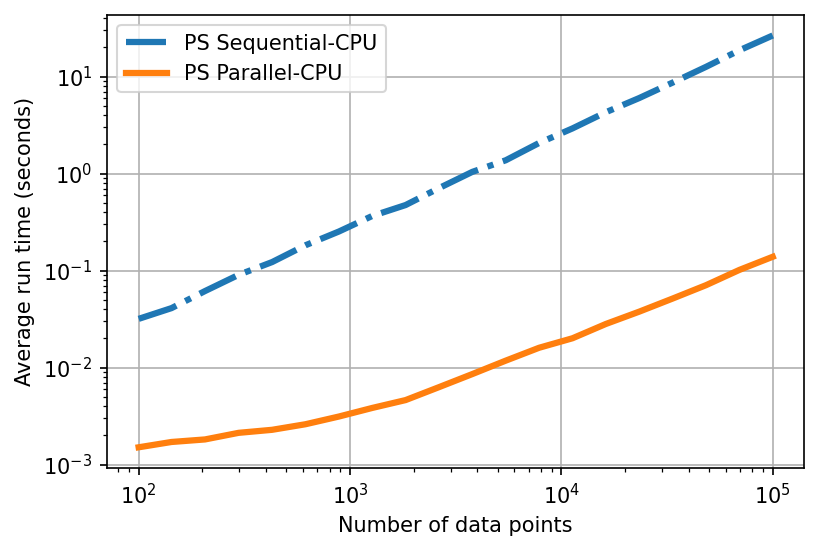

In [ ]:
fig = plt.figure(1, dpi=150)

plt.loglog(input_sizes, cpu_sequential_runtimes, label="PS Sequential-CPU", linestyle="-.", linewidth=3)
plt.loglog(input_sizes, cpu_parallel_runtimes, label="PS Parallel-CPU", linewidth=3)
plt.legend()
plt.xlabel("Number of data points")
plt.ylabel("Average run time (seconds)")
plt.grid()
plt.show()

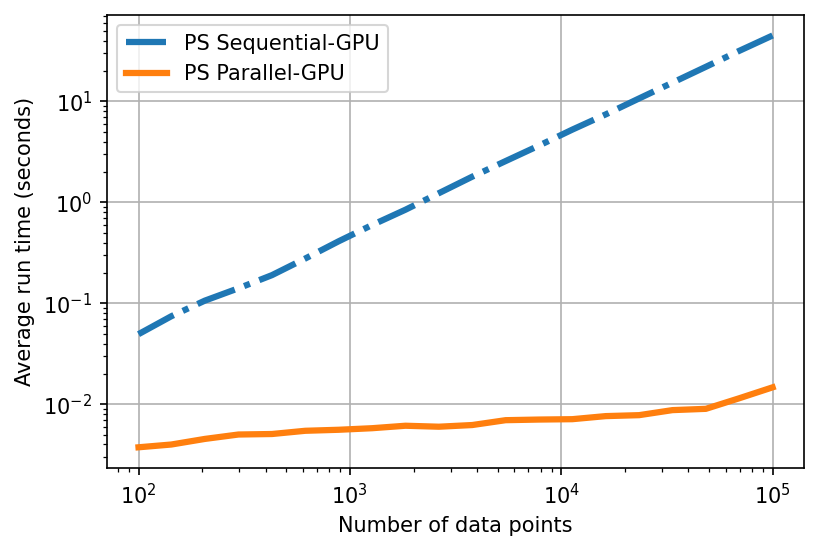

In [ ]:
fig = plt.figure(1, dpi=150)
plt.loglog(input_sizes, xpu_sequential_runtimes, label="PS Sequential-GPU", linestyle="-.", linewidth=3)
plt.loglog(input_sizes, xpu_parallel_runtimes, label="PS Parallel-GPU", linewidth=3)
plt.legend()
plt.xlabel("Number of data points")
plt.ylabel("Average run time (seconds)")
plt.grid()
plt.show()